# Training feature selection

## Description

...


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings  # Import the warnings module

import matplotlib.colors as mcolors

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [ ]:
dataset_name1 = 'sb16_17';
dataset_name2 = 'sb17_18';
dataset_name3 = 'sb18_19';
dataset_name4 = 'sb19_20';
dataset_name5 = 'sb20_21';

dataset_suffix = '_tree_cleaned';

predictor_column = 6; # Column where we start selecting the predictors
ndvi_threshold = 0; # NDVI min Threshold

In [ ]:
base_path = 'Input'
output_file1 = os.path.join(base_path, f'{dataset_name1}{dataset_suffix}.csv')
output_file2 = os.path.join(base_path, f'{dataset_name2}{dataset_suffix}.csv')
output_file3 = os.path.join(base_path, f'{dataset_name3}{dataset_suffix}.csv')
output_file4 = os.path.join(base_path, f'{dataset_name4}{dataset_suffix}.csv')
output_file5 = os.path.join(base_path, f'{dataset_name5}{dataset_suffix}.csv')
# Load the newly generated CSV file
df1 = pd.read_csv(output_file1)
df2 = pd.read_csv(output_file2)
df3 = pd.read_csv(output_file3)
df4 = pd.read_csv(output_file4)
df5 = pd.read_csv(output_file5)
# add df1 to df
df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
# print the number of rows
print(f"Number of rows: {len(df)}")
df = df.dropna()
print(df.shape)

Number of rows: 2768514
(2768514, 57)


In [4]:
# remove from df the crop types WheatMaize,WheatSunflower,WheatSoya and put them in a new df
df_wheat = df[df['Crop_type'].isin(['WheatMaize','WheatSunflower','WheatSoya'])]
df = df[~df['Crop_type'].isin(['WheatMaize','WheatSunflower','WheatSoya'])]

print(df.shape)
print(df_wheat.shape)

(2651901, 57)
(116613, 57)


In [5]:
# Separate wheat-only weeks (week 17 to 47)
df_wheat_only = df_wheat[(df_wheat['week'] >= 17) & (df_wheat['week'] <= 44)].copy()
df_wheat_only['Crop_type'] = 'Wheat'

# Separate non-wheat weeks (before 17 or after 47)
df_non_wheat = df_wheat[(df_wheat['week'] < 17) | (df_wheat['week'] > 44)].copy()

# Map back to original crop types without "Wheat" prefix
crop_map = {
    'WheatMaize': 'Maize',
    'WheatSunflower': 'Sunflower',
    'WheatSoya': 'SoyaBeans'
}
df_non_wheat['Crop_type'] = df_non_wheat['Crop_type'].map(crop_map)

# Concatenate cleaned parts back into main DataFrame
df = pd.concat([df, df_wheat_only, df_non_wheat], ignore_index=True)

# Check shapes
print("Final df shape:", df.shape)


Final df shape: (2768514, 57)


## Plot Data


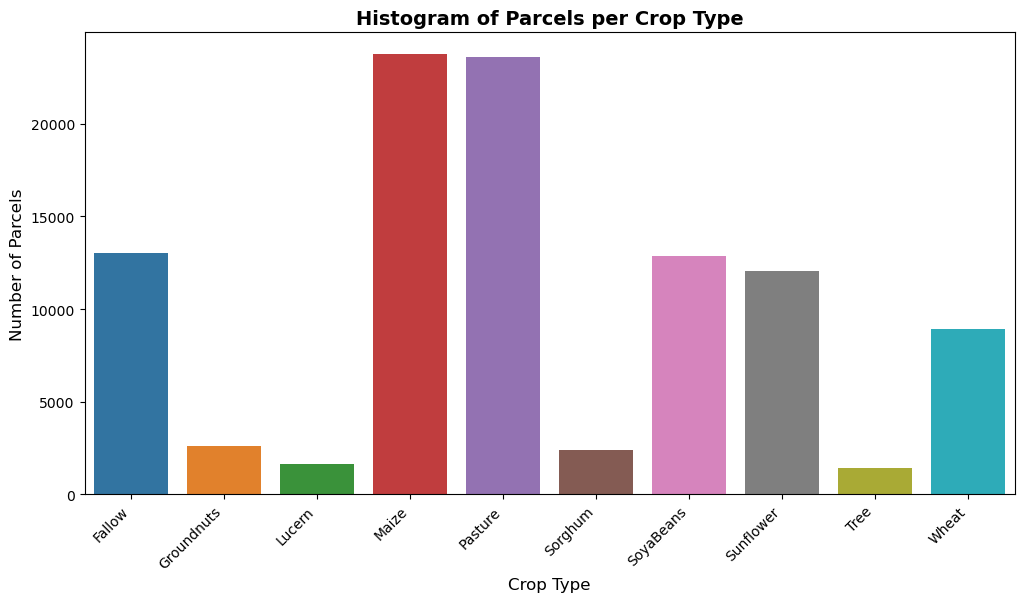

In [6]:
# Ensure Crop_type column exists
if "Crop_type" not in df.columns:
    raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# Count unique FIELDID values per Crop_type
crop_counts = df.groupby('Crop_type')['FIELDID'].nunique().reset_index()
crop_counts.columns = ['Crop_type', 'Parcel_Count']

# Define distinct colors for each crop type
colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' colormap
crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts['Crop_type'])}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='Crop_type', y='Parcel_Count', data=crop_counts,
    palette=[crop_color_map[crop] for crop in crop_counts['Crop_type']]
)

# Improve readability
ax.set_title("Histogram of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_counts['Crop_type'], rotation=45, ha='right')  # Rotate x-axis labels

plt.show()



In [7]:
# print number of parcels for each crop type
print(crop_counts)

    Crop_type  Parcel_Count
0      Fallow         13048
1  Groundnuts          2634
2      Lucern          1619
3       Maize         23745
4     Pasture         23630
5     Sorghum          2384
6   SoyaBeans         12849
7   Sunflower         12079
8        Tree          1435
9       Wheat          8908


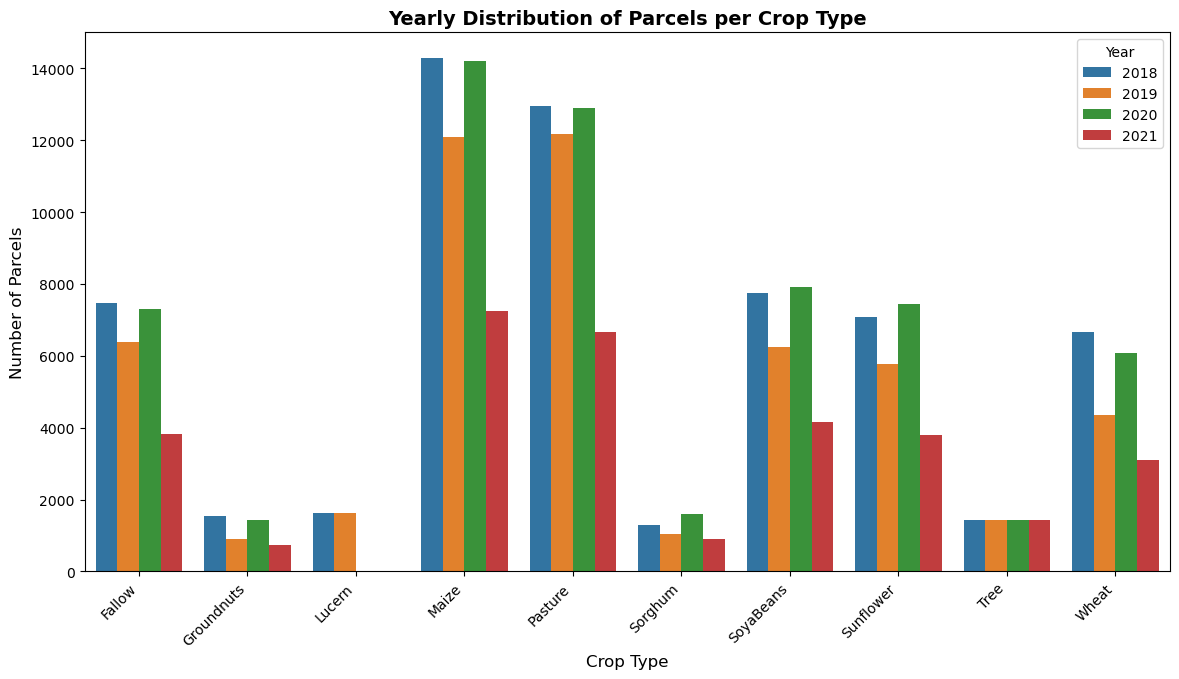

In [8]:
# Ensure required columns exist
if "Crop_type" not in df.columns or "Year" not in df.columns:
    raise ValueError("The dataframe df is missing required columns ('Crop_type' or 'Year').")

# Count unique parcels per Crop_type and Year
crop_year_counts = df.groupby(['Crop_type', 'Year'])['FIELDID'].nunique().reset_index()
crop_year_counts.columns = ['Crop_type', 'Year', 'Parcel_Count']

# Set figure size
fig, ax = plt.subplots(figsize=(14, 7))

# Use a color palette with enough distinct colors
palette = sns.color_palette("tab10", len(crop_year_counts['Year'].unique()))

# Create the bar plot
sns.barplot(
    x='Crop_type', y='Parcel_Count', hue='Year', data=crop_year_counts,
    palette=palette, dodge=True, ax=ax
)

# Improve readability
ax.set_title("Yearly Distribution of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_year_counts['Crop_type'].unique(), rotation=45, ha='right')  # Rotate x-axis labels
ax.legend(title="Year")

plt.show()


In [ ]:
# Ensure numeric
df["week"] = pd.to_numeric(df["week"], errors="coerce")
df["veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df = df.dropna(subset=["Year", "week"])
df = df[df["week"] > 0]  # ISO weeks start from 1

# Create datetime from Year, Week, and weekday=1 (Monday)
from datetime import datetime

def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df["date"] = df.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)
df = df.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in avg_ndvi["Crop_type"].unique():
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series per Crop Type (Date from Year + Week)")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()

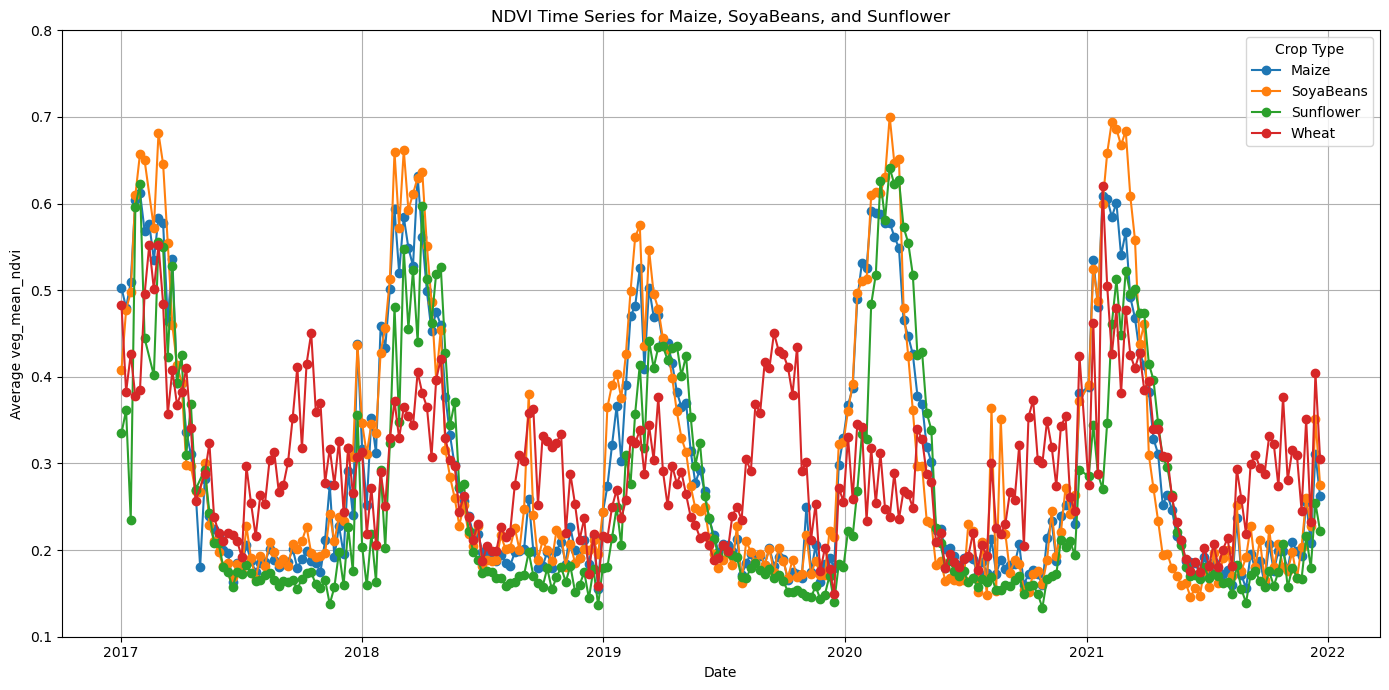

In [ ]:
# Ensure numeric
df["week"] = pd.to_numeric(df["week"], errors="coerce")
df["veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df = df.dropna(subset=["Year", "week"])
df = df[df["week"] > 0]  # ISO weeks start from 1

# Filter only for Maize, SoyaBeans, and Sunflower
df_crop = df[df["Crop_type"].isin(["Maize", "SoyaBeans", "Sunflower" , "Wheat"])].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)

df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in ["Maize", "SoyaBeans", "Sunflower", "Wheat"]:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series for Maize, SoyaBeans, and Sunflower")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()


In [ ]:
# separate irrigated and rainfed using the irrigation column
df_irrigated = df2[df2["Irrigation"] == 'Irrigated'].copy()
df_rainfed = df2[df2["Irrigation"] == 'Rainfed'].copy()

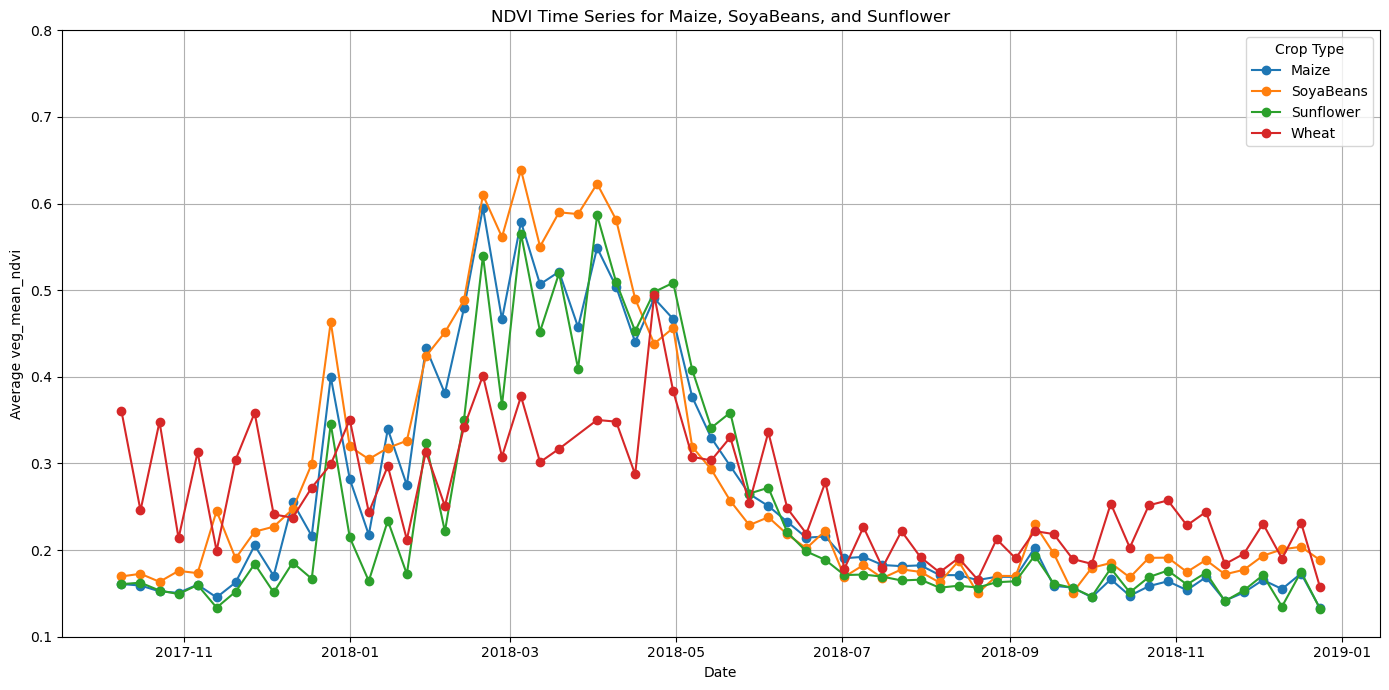

In [ ]:
# Ensure numeric
df_rainfed["week"] = pd.to_numeric(df_rainfed["week"], errors="coerce")
df_rainfed["veg_mean_ndvi"] = pd.to_numeric(df_rainfed["veg_mean_ndvi"], errors="coerce")
df_rainfed["Year"] = pd.to_numeric(df_rainfed["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df_rainfed = df_rainfed.dropna(subset=["Year", "week"])
df_rainfed = df_rainfed[df_rainfed["week"] > 0]  # ISO weeks start from 1

# Filter only for Maize, SoyaBeans, and Sunflower
df_crop = df_rainfed[df_rainfed["Crop_type"].isin(["Maize", "SoyaBeans", "Sunflower" , "Wheat"])].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)

df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in ["Maize", "SoyaBeans", "Sunflower", "Wheat"]:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Rainfed NDVI Time Series for Maize, SoyaBeans, and Sunflower")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()

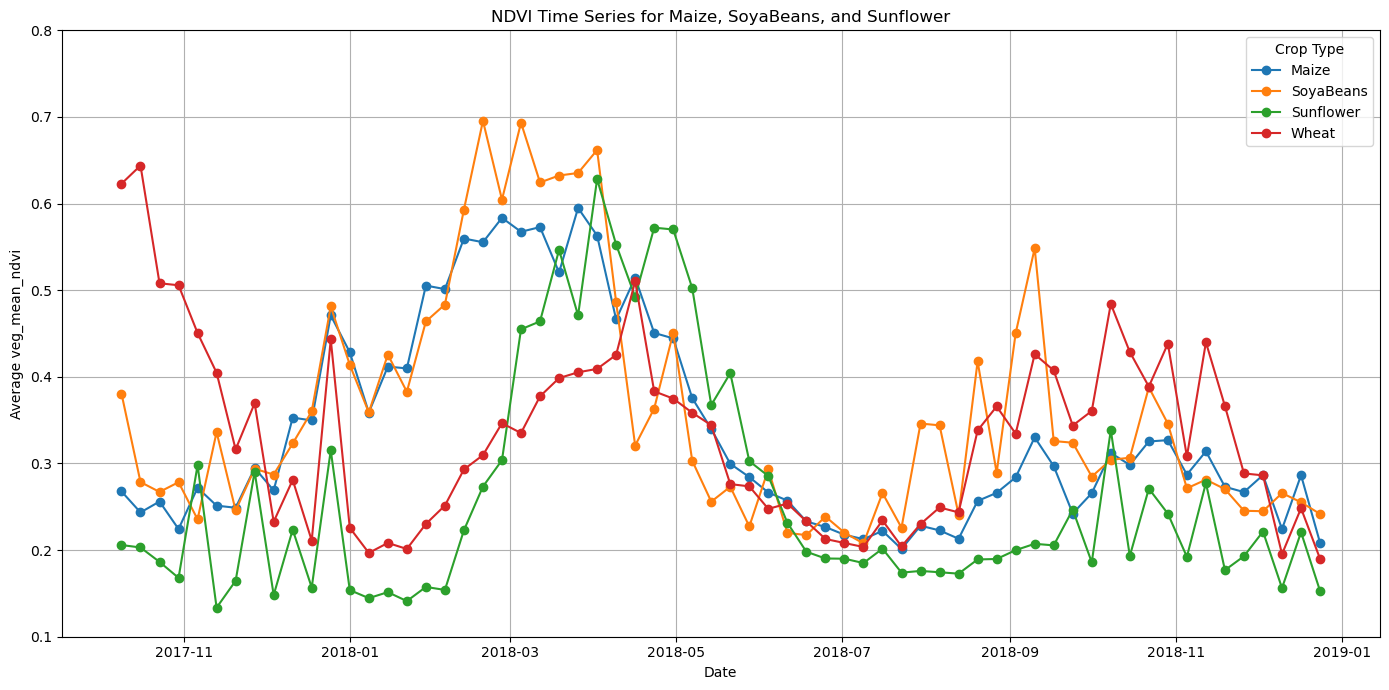

In [ ]:
# Ensure numeric
df_irrigated["week"] = pd.to_numeric(df_irrigated["week"], errors="coerce")
df_irrigated["veg_mean_ndvi"] = pd.to_numeric(df_irrigated["veg_mean_ndvi"], errors="coerce")
df_irrigated["Year"] = pd.to_numeric(df_irrigated["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df_irrigated = df_irrigated.dropna(subset=["Year", "week"])
df_irrigated = df_irrigated[df_irrigated["week"] > 0]  # ISO weeks start from 1

# Filter only for Maize, SoyaBeans, and Sunflower
df_crop = df_irrigated[df_irrigated["Crop_type"].isin(["Maize", "SoyaBeans", "Sunflower" , "Wheat"])].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)

df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in ["Maize", "SoyaBeans", "Sunflower", "Wheat"]:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Irrigated NDVI Time Series for Maize, SoyaBeans, and Sunflower")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()